In [169]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fourvec import *

In [170]:
df = pd.read_pickle('../data/nd280_nu/3plus1/m4_0.42_mzprime_0.03/MC_m4_0.42_mzprime_0.03.pckl')

In [172]:
print(len(df))

33464


In [173]:
# compute useful variables
df = df.join(pd.DataFrame((df['plm'] + df['plp']).values, 
                     columns=pd.MultiIndex.from_product([['pee'], ['t','x','y','z']])))
df.loc[:, 'recoil_mass'] = inv_mass(df['pHad']).round(6)
df.loc[:, 'ee_mass'] = inv_mass(df['pee'])
df.loc[:, 'ee_costheta'] = costheta(df['plm'], df['plp'])
df.loc[:, 'ee_beam_costheta'] = df['pee']['z']/np.sqrt(dot3_df(df['pee'], df['pee']))
df.loc[:, 'ee_momentum'] = np.sqrt(dot3_df(df['pee'], df['pee']))
df.loc[:, 'experimental_t'] = (df['plm']['t'] - df['plm']['z'] + df['plp']['t'] - df['plp']['z'])**2 +\
                               df['plm']['x']**2 + df['plm']['y']**2 + df['plp']['x']**2 + df['plp']['y']**2

ValueError: columns overlap but no suffix specified: MultiIndex([('pee', 'x'),
            ('pee', 't'),
            ('pee', 'y'),
            ('pee', 'z')],
           )

In [174]:
total_pot = 2e21

tpc_length = 100 #cm
fgd_length = 36.5 #cm
p0d_length = 240 #cm

p0d_dimensions = [210.3, 223.9, 240]
detector_splitting = {0: [0, 30.5],
                      1: [30.5, 209.6],
                      2: [209.6, 240.0]}

mol2natoms = 6.02214e23 # Avogadro's number
ton2grams = 1e6
geometry_material = {
    'hydrogen': [0, 1, 2],
    'oxygen': [1],
    'carbon': [0, 1, 2],
    'copper': [1],
    'zinc': [1],
    'lead': [0, 2],
}

material_dict = {
    0.9385: 'hydrogen',
    11.262: 'carbon',
    15.016: 'oxygen',
    59.637921: 'copper',
    61.35913: 'zinc',
    194.4572: 'lead'
}

gev_mass = dict(zip(material_dict.values(), material_dict.keys()))

molar_mass = {
    'hydrogen': 1.00784,
    'carbon': 12.0107,
    'oxygen': 15.999,
    'copper': 63.546,
    'zinc': 65.38,
    'lead': 207.2
}

mass_material = {
    'hydrogen': 3.3*2*molar_mass['hydrogen']/(2*molar_mass['hydrogen'] + molar_mass['oxygen']),
    'oxygen': 3.3*molar_mass['oxygen']/(2*molar_mass['hydrogen'] + molar_mass['oxygen']),
    'carbon': 6,
    'copper': 1.315*0.66, # percentage of copper in typical brass
    'zinc': 1.315*0.34, # percentage of zinc in typical brass
    'lead': 3.634,
}

ntarget_material = {}
for material, mass in mass_material.items():
    ntarget_material[material] = mass*ton2grams/molar_mass[material]*mol2natoms

    material_mask = (df['recoil_mass'] == gev_mass[material])
    df.loc[material_mask, 'actual_weight'] = df.loc[material_mask, 'weight'].values * ntarget_material[material] * total_pot

In [175]:
rg = np.random.default_rng()

df.loc[:, ('int_point', 't')] = 0
df.loc[:, ('int_point', 'x')] = rg.uniform(0, p0d_dimensions[0], len(df))
df.loc[:, ('int_point', 'y')] = rg.uniform(0, p0d_dimensions[1], len(df))

for material_mass, material in material_dict.items():
    material_mask = (df['recoil_mass'] == material_mass)
    region = rg.choice(geometry_material[material], len(df))

    for splitting, boundaries in detector_splitting.items():
        region_mask = (region == splitting)
        total_mask = material_mask & region_mask
        df.loc[total_mask, ('int_point', 'z')] = rg.uniform(*boundaries, total_mask.sum())

In [176]:
ctaus = [0.1, 1, 10, 100, 1000]
actual_ctau = 0.05
for ctau in ctaus:
    aux_decay_point = df['int_point'] + df['decay_point']*ctau/actual_ctau
    df = df.join(pd.DataFrame(aux_decay_point.values, 
                     columns=pd.MultiIndex.from_product([[f'decay_point_{ctau}'], ['t','x','y','z']])))
    
    df.loc[:, f'decay_in_tpc_{ctau}'] = (((p0d_length < df[f'decay_point_{ctau}']['z']) & (df[f'decay_point_{ctau}']['z'] < (p0d_length + tpc_length)) |
    (p0d_length + tpc_length + fgd_length < df[f'decay_point_{ctau}']['z']) & (df[f'decay_point_{ctau}']['z'] < (p0d_length + tpc_length + fgd_length + tpc_length)) |
    (p0d_length + 2*(tpc_length + fgd_length) < df[f'decay_point_{ctau}']['z']) & (df[f'decay_point_{ctau}']['z'] < (p0d_length + 2*(tpc_length + fgd_length) + tpc_length)))) &\
    (detector_splitting[0][0] < df[f'decay_point_{ctau}']['x']) & (df[f'decay_point_{ctau}']['x'] < detector_splitting[0][1]) &\
    (detector_splitting[1][0] < df[f'decay_point_{ctau}']['y']) & (df[f'decay_point_{ctau}']['y'] < detector_splitting[1][1])

In [177]:
selection = (df['ee_beam_costheta'] > 0.99) &\
            (df['ee_costheta'] > 0) &\
            (df['experimental_t'] < 0.03) &\
            (df['ee_momentum'] > 0.150)

In [186]:
df['weight'].sum()

3.622854318019939e-38

Text(0.5, 0, 'e+e- deposited energy [GeV]')

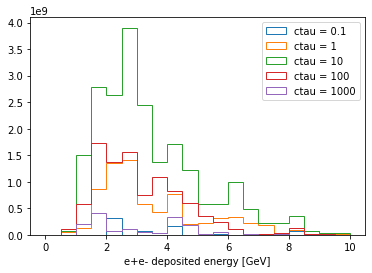

In [182]:
for ctau in ctaus:
    total_selection = selection & df[f'decay_in_tpc_{ctau}']
    out = plt.hist(df['pee']['t'][total_selection], bins=20, range=(0, 10), weights=df['actual_weight'][total_selection], label=f'ctau = {ctau}', histtype='step')

plt.legend()
plt.xlabel('e+e- deposited energy [GeV]')

In [187]:
df['ee_mass']

0        0.03
1        0.03
2        0.03
3        0.03
4        0.03
         ... 
33459    0.03
33460    0.03
33461    0.03
33462    0.03
33463    0.03
Name: ee_mass, Length: 33464, dtype: float64

Text(0.5, 0, 'e+e- openin angle')

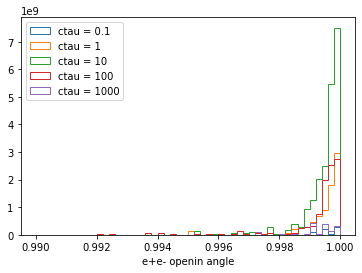

In [181]:
for ctau in ctaus:
    total_selection = selection & df[f'decay_in_tpc_{ctau}']
    out = plt.hist(df['ee_costheta'][total_selection], bins=50, range=(0.99, 1), weights=df['actual_weight'][total_selection], label=f'ctau = {ctau}', histtype='step')

plt.legend(loc='upper left')
plt.xlabel('e+e- openin angle')

In [197]:
inv_mass(df['pnu']+df['plp']+df['plm'])

0        0.06
1        0.06
2        0.06
3        0.06
4        0.06
         ... 
33459    0.06
33460    0.06
33461    0.06
33462    0.06
33463    0.06
Length: 33464, dtype: float64

In [199]:
inv_mass(df['plp'])

0        0.000511
1        0.000511
2        0.000511
3        0.000511
4        0.000511
           ...   
33459    0.000511
33460    0.000511
33461    0.000511
33462    0.000511
33463    0.000511
Length: 33464, dtype: float64